In [42]:
from math import sqrt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GRU, Bidirectional
from tensorflow.keras.losses import mean_squared_error
from numpy.core._multiarray_umath import concatenate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
import tensorflow as tf
from keras import backend as K     
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

def swish(inputs):
    return (K.sigmoid(inputs) * inputs)
    
def h_swish(inputs):
    return inputs * tf.nn.relu6(inputs + 3) / 6


#函数绑定，将激活函数swish和h_swish添加到keras框的Activation类中
get_custom_objects().update({'swish': Activation(swish)})    
get_custom_objects().update({'h_swish': Activation(h_swish)})

# supervised监督学习函数


def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s%d(t-%d)' % (columns[j], j + 1, i))
                  for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s%d(t)' % (columns[j], j + 1)) for j in range(n_vars)]
        else:
            names += [('%s%d(t+%d)' % (columns[j], j + 1, i))
                      for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        clean_agg = agg.dropna()
    return clean_agg

dataset = pd.read_csv(
    'task_usage_preprocessed.csv')

dataset_columns = dataset.columns
values = dataset.values
print(dataset)

# 归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# 监督学习
reframed = series_to_supervised(scaled, dataset_columns, 1, 1)
values = reframed.values

# 学习与检测数据的划分
n_train_hours = 400
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# 监督学习结果划分
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

# 为了在LSTM中应用该数据，需要将其格式转化为3D format，即[Samples, timesteps, features]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


     Time  mean_cpu_usage_rate  ...  maximum_cpu_usage  sampled_cpu_usage
0      10             0.176242  ...           0.730918           0.097729
1      15             0.138201  ...           0.552451           0.082357
2      20             0.139490  ...           0.553337           0.082896
3      25             0.160044  ...           0.601842           0.108727
4      30             0.154684  ...           0.571890           0.098590
..    ...                  ...  ...                ...                ...
583  2925             0.148851  ...           0.554342           0.092319
584  2930             0.191400  ...           0.660877           0.125024
585  2935             0.207017  ...           0.723978           0.133909
586  2940             0.206525  ...           0.739635           0.130044
587  2945             0.079510  ...           0.258525           0.055571

[588 rows x 10 columns]


In [43]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5,
                 strides=1, padding="causal",
                 activation="relu"))
model.add(Bidirectional(
    GRU(
        32,
        input_shape=(
            train_X.shape[1],
            train_X.shape[2]),
        return_sequences=True)))
model.add(Bidirectional(
    GRU(16, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dense(16, activation="swish"))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.Huber(),
    optimizer='adam',
    metrics=["mse"])
history = model.fit(
    train_X,
    train_y,
    epochs=300,
    batch_size=72,
    validation_data=(
        test_X,
        test_y),
verbose = 2)

Epoch 1/300
6/6 - 1s - loss: 0.0764 - mse: 0.1528 - val_loss: 0.0229 - val_mse: 0.0457
Epoch 2/300
6/6 - 0s - loss: 0.0374 - mse: 0.0747 - val_loss: 0.0075 - val_mse: 0.0150
Epoch 3/300
6/6 - 0s - loss: 0.0154 - mse: 0.0307 - val_loss: 0.0215 - val_mse: 0.0430
Epoch 4/300
6/6 - 0s - loss: 0.0186 - mse: 0.0372 - val_loss: 0.0213 - val_mse: 0.0426
Epoch 5/300
6/6 - 0s - loss: 0.0145 - mse: 0.0289 - val_loss: 0.0106 - val_mse: 0.0211
Epoch 6/300
6/6 - 0s - loss: 0.0131 - mse: 0.0262 - val_loss: 0.0088 - val_mse: 0.0176
Epoch 7/300
6/6 - 0s - loss: 0.0127 - mse: 0.0254 - val_loss: 0.0101 - val_mse: 0.0203
Epoch 8/300
6/6 - 0s - loss: 0.0128 - mse: 0.0257 - val_loss: 0.0134 - val_mse: 0.0269
Epoch 9/300
6/6 - 0s - loss: 0.0117 - mse: 0.0235 - val_loss: 0.0142 - val_mse: 0.0283
Epoch 10/300
6/6 - 0s - loss: 0.0109 - mse: 0.0219 - val_loss: 0.0116 - val_mse: 0.0233
Epoch 11/300
6/6 - 0s - loss: 0.0100 - mse: 0.0201 - val_loss: 0.0115 - val_mse: 0.0230
Epoch 12/300
6/6 - 0s - loss: 0.0098 - ms

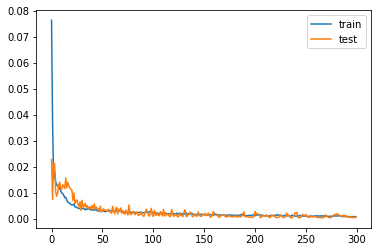

Test RMSE: 0.03908302
Test MSE: 0.00152748


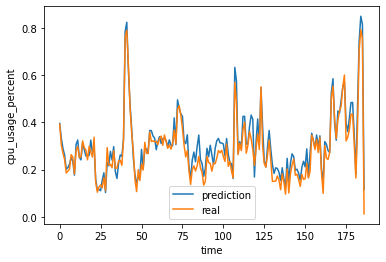

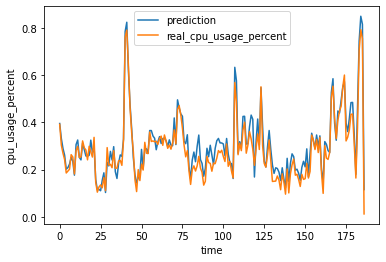

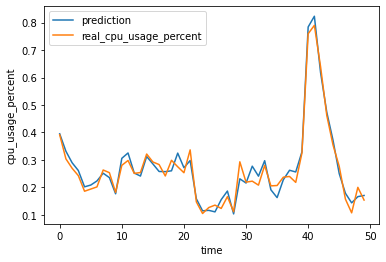

In [44]:
#画图
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make the prediction
yHat = model.predict(test_X)

inv_yHat = concatenate((yHat, test_x[:, 1:]), axis=1)   # 数组拼接
inv_yHat = inv_yHat[:, 0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_x[:, 1:]), axis=1)
inv_y = inv_y[:, 0]

rmse = sqrt(mean_squared_error(inv_yHat, inv_y))
print('Test RMSE: %.8f' % rmse)
mse = mean_squared_error(inv_yHat, inv_y)
print('Test MSE: %.8f' % mse)

yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((yhat, yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = inv_yhat[:, 0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_y, test_X_reshaped[:, 1:]), axis=1)
inv_y = inv_y[:, 0]
plt.plot(inv_yhat, label='prediction')
plt.plot(inv_y, label='real')
plt.xlabel('time')
plt.ylabel('cpu_usage_percent')
plt.legend()
plt.show()

plt.plot(inv_yhat[:500], label='prediction')
plt.plot(inv_y[:500], label='real_cpu_usage_percent')
plt.xlabel('time')
plt.ylabel('cpu_usage_percent')
plt.legend()
plt.show()

plt.plot(inv_yhat[:50], label='prediction')
plt.plot(inv_y[:50], label='real_cpu_usage_percent')
plt.xlabel('time')
plt.ylabel('cpu_usage_percent')
plt.legend()
plt.show()